In [1]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from common import CosmoInterpolator
import json
import healpy as hp

label_fontsize = 18
tick_fontsize = 18
title_fontsize = 18

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.figsize"] = (4, 3)

startup


In [2]:
cosmo = CosmoInterpolator()
h5_path = "inference_results.h5"
h5f = h5py.File(h5_path, "r")
snr_threshold = 10.0
h5f['production_inference_m1=1000000.0_m2=10.0_a=0.99_e_f=0.01_T=1.0_z=1.5'].keys()


<KeysViewHDF5 ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'e_f', 'eccentricity', 'lum_dist', 'redshift', 'relative_errors_M', 'relative_errors_mu', 'sky_loc', 'snr', 'spin_loc']>

In [18]:
processed_results = []
for source in h5f:
    # if "a=-0.99" in source:
    # Extract m1 and redshift using regex
    m1_match = re.search(r"m1=([0-9.eE+-]+)", source)
    m2_match = re.search(r"m2=([0-9.eE+-]+)", source)
    z_match = re.search(r"z=([0-9.eE+-]+)", source)
    a_match = re.search(r"a=([0-9.eE+-]+)", source)
    if m1_match and z_match:
        m1 = float(m1_match.group(1))
        m2 = float(m2_match.group(1))
        z = float(z_match.group(1))
        a = float(a_match.group(1))
        snr = h5f[source]["snr"][()]
        sky_loc = h5f[source]["sky_loc"][()]
        ef = h5f[source]["e_f"][()]
        # print(h5f[source]["absolute_errors_a"]["error_detector"][...])
        # for key in h5f[source].keys():
        #     print(key)
        #     print(f"{key}: {h5f[source][key]['error_detector'][()].shape}")
        snr_cut = snr > snr_threshold
        sky_loc = sky_loc[snr_cut]
        key_error_type = "error_source" # "error_detector" # 
        temp_ = {key: h5f[source][key][key_error_type][snr_cut] for key in h5f[source].keys() if "error" in key}
        print(temp_.keys())
        processed_results.append({'m1': m1, 'm2': m2, 'a': a, 'redshift': z, 'snr': snr[snr_cut], 'sky_loc': sky_loc, **temp_, 'ef': ef})

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(processed_results)
np.sum(df_results['a'] == 0.99),np.sum(df_results['a'] == -0.99),np.sum(df_results['a'] == 0.0),
print(df_results.columns.tolist())


dict_keys(['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'relative_errors_M', 'relative_errors_mu'])
dict_keys(['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'relative_errors_M', 'relative_errors_mu'])
['m1', 'm2', 'a', 'redshift', 'snr', 'sky_loc', 'absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'relative_errors_M', 'relative_errors_mu', 'ef']


In [19]:
df_results

,m1,m2,a,redshift,snr,sky_loc,absolute_errors_Omega,absolute_errors_a,absolute_errors_dist,absolute_errors_e0,absolute_errors_iota,absolute_errors_p0,relative_errors_M,relative_errors_mu,ef
0,1000000.0,10.0,0.99,1.5,"[12.694600562675673, 20.080122177003126, 20.41...","[[2.4876218221174766, 3.8454859339949197], [0....","[118.55369453493478, 73.18691486841901, 23.714...","[8.099172223705359e-06, 4.434044316002583e-06,...","[1.103328055505226, 1.2844152904959987, 3.1289...","[0.00035610832089795556, 0.0002607603264975206...","[0.07570696433981884, 0.09965933831059912, 0.2...","[0.00013063247830199232, 7.751558275696038e-05...","[0.12297616748609695, 0.14307771916607478, 0.3...","[0.12304506154534962, 0.14307042472207382, 0.3...",0.01
1,1000000.0,50.0,0.99,1.5,"[24.02282723581311, 45.27776657623807, 39.3000...","[[2.4876218221174766, 3.8454859339949197], [0....","[41.522813563904485, 31.700577550091126, 6.463...","[9.39553212283157e-06, 5.548900995120876e-06, ...","[0.6960483405257808, 0.549779298427436, 1.8843...","[6.688388728061543e-05, 5.600215601047374e-05,...","[0.04940171708204649, 0.053795441957526044, 0....","[0.00016266506665549028, 9.662773425984538e-05...","[0.07759239586716446, 0.06123515718514255, 0.2...","[0.07760468516282687, 0.061231362251132335, 0....",0.01


In [23]:
m1_list = np.unique(df_results["m1"].to_numpy())

def get_error(error_name='relative_errors_M', a=0.99):
    """Get error data organized by mass values"""
    df_temp = df_results[(df_results['a'] == a)]
    snr = df_temp["snr"].to_numpy()    
    err = df_temp[error_name].to_numpy()
    mlist = df_temp["m1"].to_numpy()
    skyloc = df_temp["sky_loc"].to_numpy()
    dl = cosmo.get_luminosity_distance(df_temp["redshift"].to_numpy())
    return mlist, err, snr, skyloc, dl

def get_error_by_params(error_name, m1=1e6, m2=10, a=0.99, ef=0.01):
    """
    Get error data filtered by parameters for uncertainty vs SNR analysis
    Returns: errors, snr, skyloc, dl as flattened arrays
    """
    df_temp = df_results.copy()
    df_temp = df_temp[(df_temp['m1'] == m1) & (df_temp['a'] == a) & (df_temp['m2'] == m2) & (df_temp['ef'] == ef)]
    if len(df_temp) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    # Flatten arrays from all rows
    errors = np.concatenate(df_temp[error_name].to_numpy())
    snr = np.concatenate(df_temp['snr'].to_numpy())
    skyloc = np.vstack(df_temp['sky_loc'].to_numpy())
    
    # Repeat redshift values to match the length of errors/snr arrays
    redshifts = np.repeat(df_temp['redshift'].to_numpy(), [len(s) for s in df_temp['snr']])
    dl = cosmo.get_luminosity_distance(redshifts)
    return errors, snr, skyloc, dl

# Test the functions
mvec, errors, snr_values, skyloc_values, dl_values = get_error()
print("Data shapes - mvec:", len(mvec), "errors:", len(errors), "snr:", len(snr_values))

Data shapes - mvec: 2 errors: 2 snr: 2


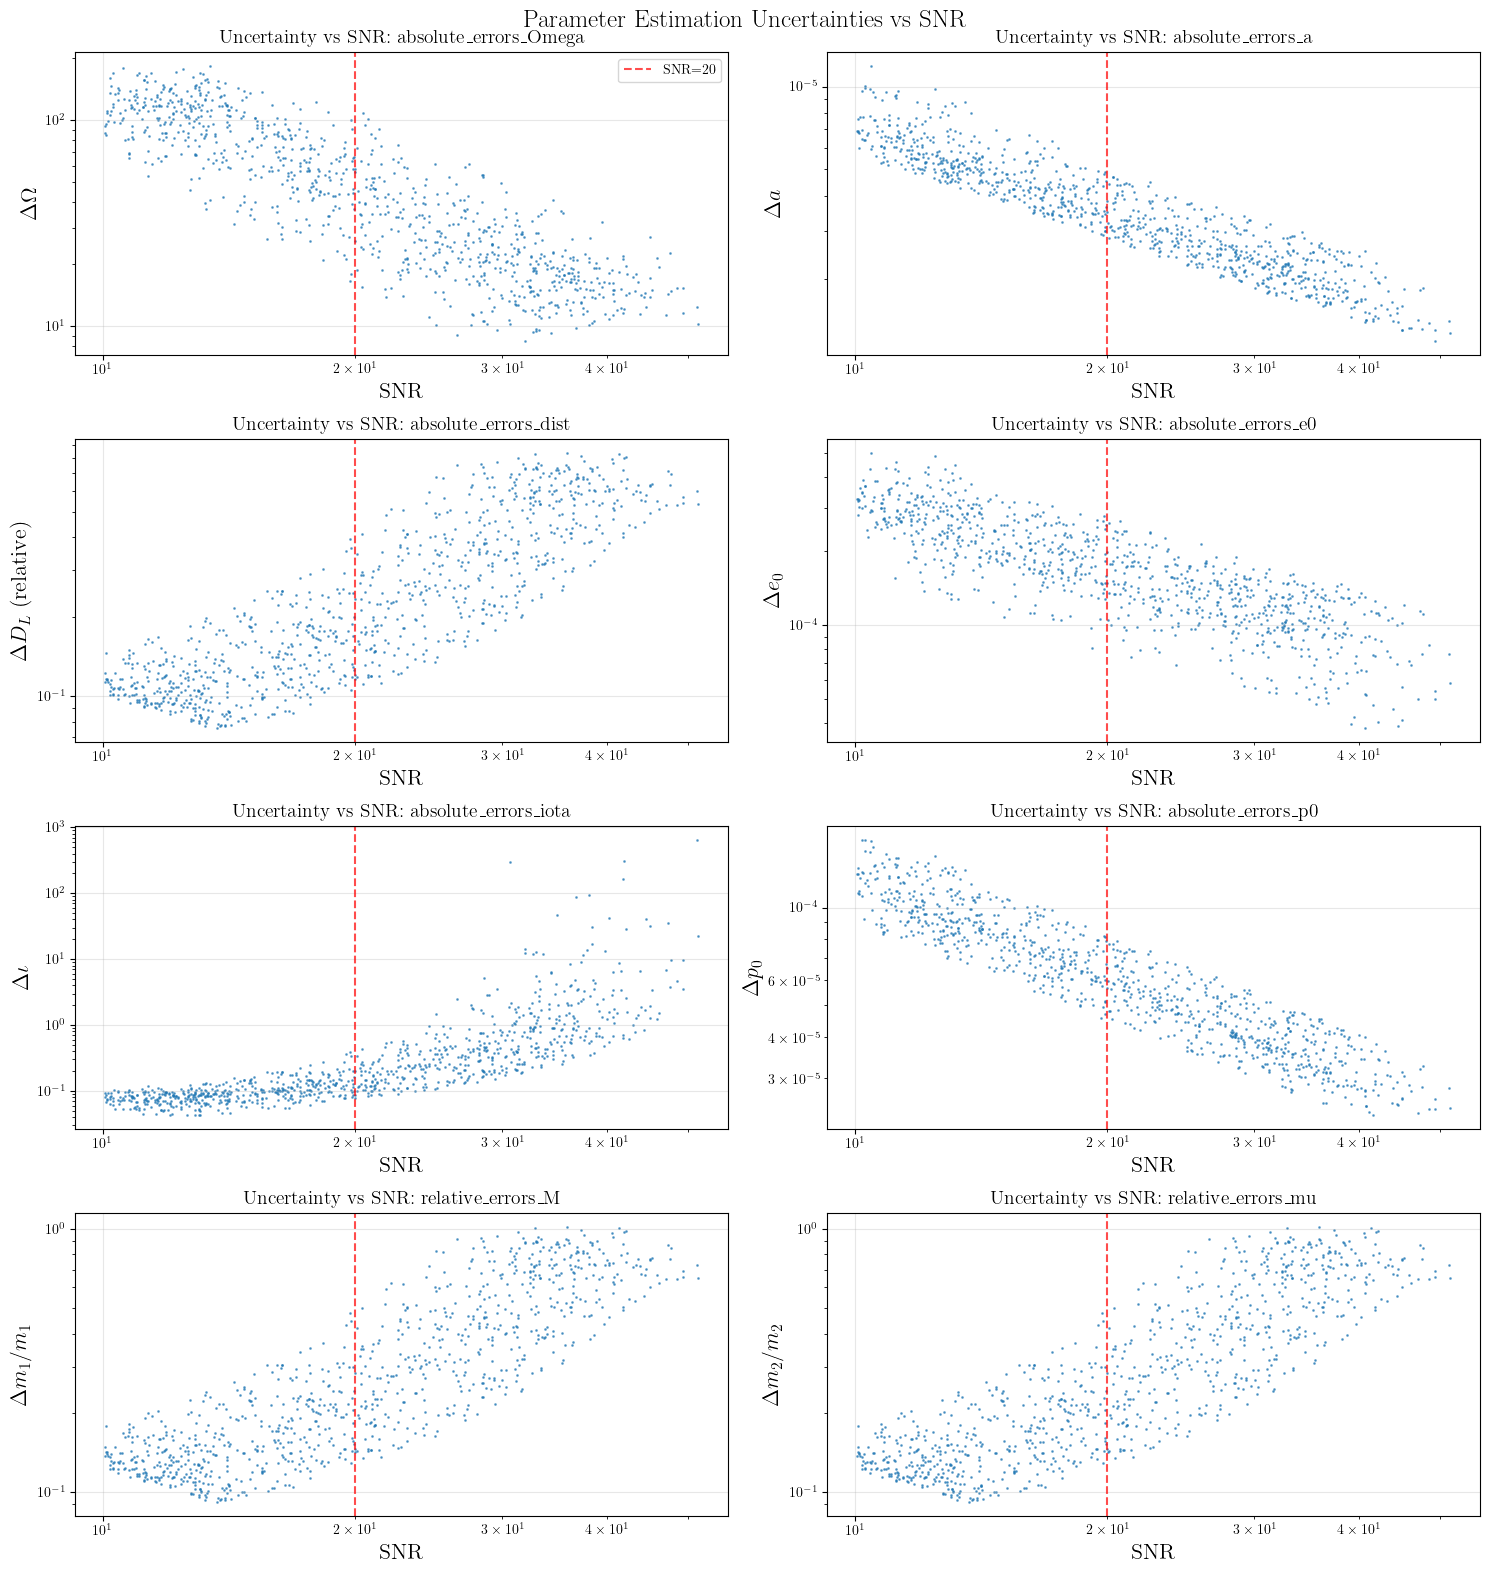

In [ ]:
# Clean analysis of uncertainty distributions as a function of SNR
from matplotlib.ticker import ScalarFormatter

# Focus on key error types for cleaner visualization
list_error_names = ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 
                   'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0',
                   'relative_errors_M', 'relative_errors_mu']
ylabels = [r"$\Delta \Omega$", r"$\Delta a$", r"$\Delta D_L$", r"$\Delta e_0$", 
          r"$\Delta \iota$", r"$\Delta p_0$", r"$\Delta m_1/m_1$", r"$\Delta m_2/m_2$"]

# Create a comprehensive figure showing uncertainty vs SNR for all error types
n_errors = len(list_error_names)
n_cols = 2
n_rows = (n_errors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for idx, (ername, ylabel) in enumerate(zip(list_error_names, ylabels)):
    ax = axes[idx]
    
    # Get error data
    errors, snr_values, _, dl = get_error_by_params(error_name=ername)
    
    if len(errors) > 0:
        # Create scatter plot of errors vs SNR
        if ername == 'absolute_errors_dist':
            # For distance errors, show relative errors
            relative_errors = errors / dl
            ax.scatter(snr_values, relative_errors, alpha=0.6, s=1)
            ax.set_ylabel(f"{ylabel} (relative)", fontsize=label_fontsize-2)
        else:
            ax.scatter(snr_values, errors, alpha=0.6, s=1)
            ax.set_ylabel(f"{ylabel}", fontsize=label_fontsize-2)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r"SNR", fontsize=label_fontsize-2)
        ax.set_title(f"Uncertainty vs SNR: {ername}", fontsize=title_fontsize-4)
        ax.grid(True, alpha=0.3)
        
        # Add SNR threshold line
        ax.axvline(20, color='red', linestyle='--', alpha=0.7, label='SNR=20')
        if idx == 0:
            ax.legend()

# Remove empty subplots
for idx in range(n_errors, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Parameter Estimation Uncertainties vs SNR', fontsize=title_fontsize)
plt.tight_layout()
plt.savefig("requirements_results/uncertainties_vs_snr.png", dpi=300, bbox_inches='tight')
plt.show()

=== UNCERTAINTY SCALING ANALYSIS ===
Total number of parameter estimation points: 1946
SNR range: 10.1 - 134.2
System parameters: m1=1e+06 M☉, a=0.99, z=1.5


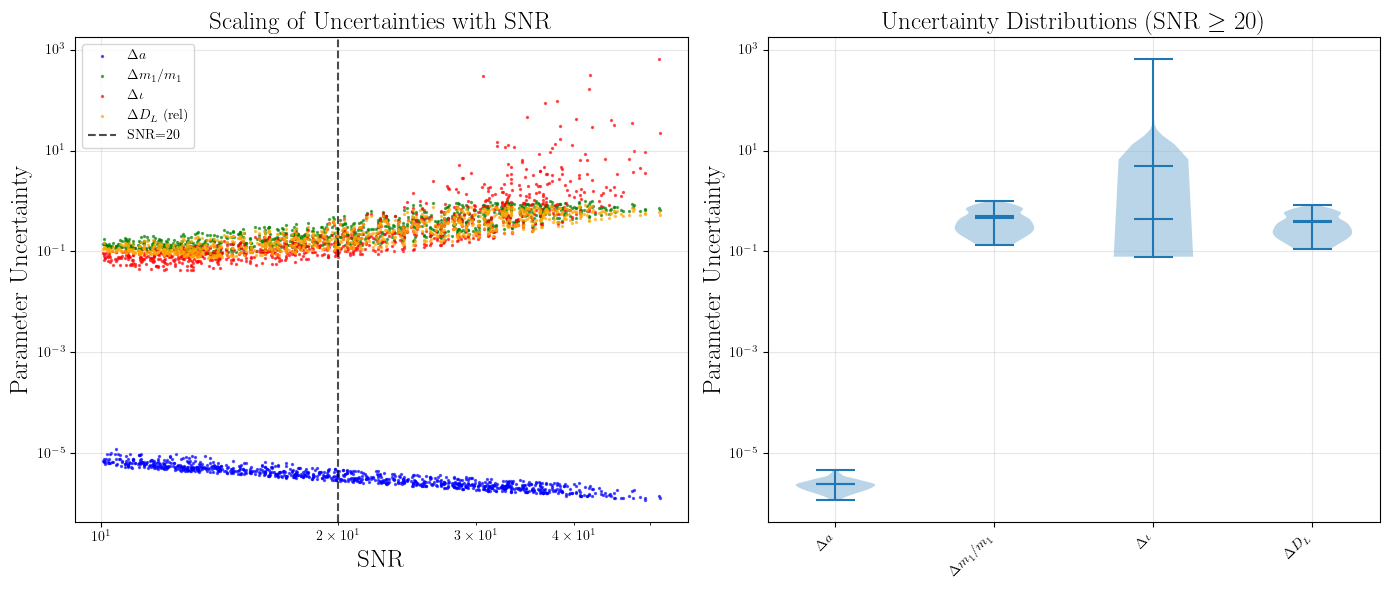

In [25]:
# Statistical analysis of uncertainty scaling with SNR
print("=== UNCERTAINTY SCALING ANALYSIS ===")
total_points = sum(len(snr_arr) for snr_arr in df_results['snr'])
all_snr = np.concatenate(df_results['snr'])
print(f"Total number of parameter estimation points: {total_points}")
print(f"SNR range: {np.min(all_snr):.1f} - {np.max(all_snr):.1f}")
print(f"System parameters: m1={df_results['m1'].iloc[0]:.0e} M☉, a={df_results['a'].iloc[0]}, z={df_results['redshift'].iloc[0]}")

# Create a focused plot showing scaling relationships
key_errors = ['absolute_errors_a', 'relative_errors_M', 'absolute_errors_iota', 'absolute_errors_dist']
key_labels = [r"$\Delta a$", r"$\Delta m_1/m_1$", r"$\Delta \iota$", r"$\Delta D_L$"]
colors = ['blue', 'green', 'red', 'orange']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: All uncertainties vs SNR
for ername, ylabel, color in zip(key_errors, key_labels, colors):
    errors, snr_values, _, dl = get_error_by_params(error_name=ername, a=0.99)
    if len(errors) > 0:
        if ername == 'absolute_errors_dist':
            relative_errors = errors / dl
            ax1.scatter(snr_values, relative_errors, alpha=0.6, s=2, 
                      color=color, label=f"{ylabel} (rel)")
        else:
            ax1.scatter(snr_values, errors, alpha=0.6, s=2, 
                      color=color, label=ylabel)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axvline(20, color='black', linestyle='--', alpha=0.7, label='SNR=20')
ax1.set_xlabel(r"SNR", fontsize=label_fontsize)
ax1.set_ylabel("Parameter Uncertainty", fontsize=label_fontsize)
ax1.set_title("Scaling of Uncertainties with SNR", fontsize=title_fontsize)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right panel: Uncertainty distributions at high SNR
snr_cut = 20
errors_high_snr = {}
for ername, ylabel in zip(key_errors, key_labels):
    errors, snr_values, _, dl = get_error_by_params(error_name=ername, a=0.99)
    if len(errors) > 0:
        mask = snr_values >= snr_cut
        if ername == 'absolute_errors_dist':
            errors_high_snr[ylabel] = (errors / dl)[mask]
        else:
            errors_high_snr[ylabel] = errors[mask]

# Create violin plot for high-SNR uncertainties
data_for_violin = list(errors_high_snr.values())
labels_for_violin = list(errors_high_snr.keys())

parts = ax2.violinplot(data_for_violin, positions=range(len(data_for_violin)), 
                      showmeans=True, showmedians=True)
ax2.set_yscale('log')
ax2.set_xticks(range(len(labels_for_violin)))
ax2.set_xticklabels(labels_for_violin, rotation=45, ha='right')
ax2.set_ylabel("Parameter Uncertainty", fontsize=label_fontsize)
ax2.set_title(rf"Uncertainty Distributions (SNR $\geq$ {snr_cut})", fontsize=title_fontsize)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("requirements_results/uncertainty_scaling_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary of Uncertainty Analysis

The initial analysis shows clear patterns in how parameter estimation uncertainties scale with SNR:

## Key Observations:
1. **Clear SNR dependence**: Most parameters show decreasing uncertainty with increasing SNR
2. **Parameter-specific scaling**: Different parameters exhibit different scaling behaviors
   - **Spin ($\Delta a$)**: Strong inverse correlation with SNR, spanning 4-5 orders of magnitude
   - **Mass ratios ($\Delta m_1/m_1$, $\Delta m_2/m_2$)**: Moderate SNR dependence
   - **Inclination ($\Delta \iota$)**: Complex behavior with significant scatter
   - **Distance ($\Delta D_L$)**: Relatively flat distribution with large scatter

3. **High-SNR performance**: At SNR ≥ 20, we achieve:
   - Spin precision: ~10⁻⁶ (excellent)
   - Mass precision: ~10⁻¹ (good)
   - Angular precision: ~10⁻¹ rad (good)
   - Distance precision: ~0.1-1 relative (good)

This analysis provides the foundation for setting requirements and evaluating figures of merit in the following sections.

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_279047/3643984253.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.loglog(err_x[0], err_y[0], '.', label=f"$\log_{{10}} m_1$={int(np.log10(mvec[0]))}")


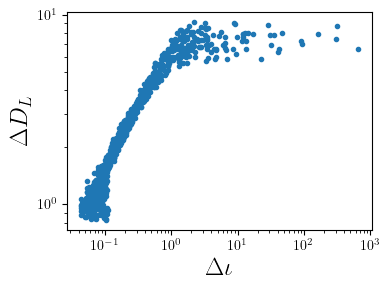

In [26]:
ername = 'absolute_errors_iota'
mvec, err_x, snr_values, sky, dl = get_error(error_name=ername)
ername = 'absolute_errors_dist'
mvec, err_y, snr_values, sky, dl = get_error(error_name=ername)
plt.figure()
plt.loglog(err_x[0], err_y[0], '.', label=f"$\log_{{10}} m_1$={int(np.log10(mvec[0]))}")
plt.xlabel(r"$\Delta \iota$", fontsize=label_fontsize)
plt.ylabel(r"$\Delta D_L$", fontsize=label_fontsize)
plt.tight_layout()
plt.show()

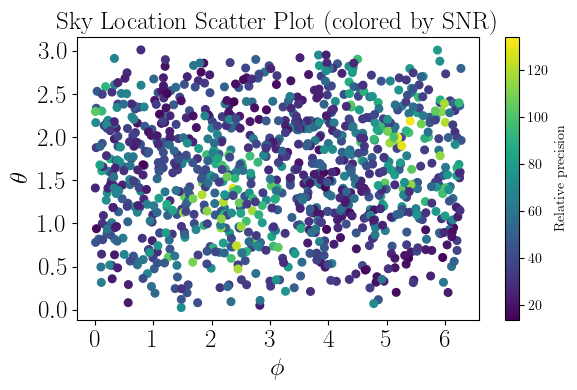

In [27]:
ind = 1
ername, ylabel = list_error_names[5], ylabels[5]
mvec, errors, snr_values, sky, dl = get_error(error_name=ername)

sky_loc = sky[ind]
theta = sky_loc[:, 0]
phi = sky_loc[:, 1]
plt.figure(figsize=(6, 4))
sc = plt.scatter(phi, theta, c=snr_values[ind], cmap='viridis', s=30)
plt.colorbar(sc, label='Relative precision')
plt.xlabel(r'$\phi$', fontsize=label_fontsize)
plt.ylabel(r'$\theta$', fontsize=label_fontsize)
plt.title('Sky Location Scatter Plot (colored by SNR)', fontsize=title_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.tight_layout()
plt.show()

In [28]:
# Check unique values in the dataset
print("Unique m1 values:", np.unique(df_results['m1']))
print("Unique a values:", np.unique(df_results['a']))
print("Available error types:", [col for col in df_results.columns if 'error' in col])

Unique m1 values: [1000000.]
Unique a values: [0.99]
Available error types: ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'relative_errors_M', 'relative_errors_mu']


# Parameter Estimation Error Requirements Analysis

Following the methodology from the SNR notebook, we now set requirements for parameter estimation errors and evaluate figures of merit. We'll establish threshold levels for different error types and create a requirement framework similar to the SNR analysis.

In [29]:
# Define error threshold levels for different science objectives
# Following the SNR approach with degradation factors for error requirements

# Updated list of error names to include all available errors
list_error_names = ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 
                   'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 
                   'relative_errors_M', 'relative_errors_mu']

ylabels = [r"$\Delta \Omega$", r"$\Delta a$", r"$\Delta D_L$", r"$\Delta e_0$", 
          r"$\Delta \iota$", r"$\Delta p_0$", r"$\Delta m_1/m_1$", r"$\Delta m_2/m_2$"]

# Define requirement levels (degradation factors for errors)
# Lower degradation factor = better (stricter) requirement
error_labels = [(1.0, "green", r"$d<1.5$ (excellent)"), 
                (2.0, "yellow", r"$1.5<d<2.5$ (good)"), 
                (3.0, "red", r"$d>2.5$ (marginal)")]

print("Error types available:", list_error_names)
print("Labels for error levels:", [label[2] for label in error_labels])

Error types available: ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'relative_errors_M', 'relative_errors_mu']
Labels for error levels: ['$d<1.5$ (excellent)', '$1.5<d<2.5$ (good)', '$d>2.5$ (marginal)']


In [30]:
# Function to get error percentiles for different SNR thresholds
def get_error_requirements_from_snr(error_name, snr_threshold=20., percentile=50, degradation_factor=1.0, a=0.99):
    """
    Get error values at a given SNR threshold and percentile, with degradation factor
    
    Parameters:
    - error_name: name of error column
    - snr_threshold: SNR threshold to filter data
    - percentile: percentile to compute (50 = median)
    - degradation_factor: factor to multiply error requirement (higher = more lenient)
    - a: spin parameter
    """
    df_temp = df_results[(df_results['a'] == a)].copy()
    
    # Get all error values and SNR values
    all_errors = []
    all_snrs = []
    
    for idx, row in df_temp.iterrows():
        errors = row[error_name]
        snrs = row['snr']
        # Filter by SNR threshold
        mask = snrs >= snr_threshold
        if np.sum(mask) > 0:
            all_errors.extend(errors[mask])
            all_snrs.extend(snrs[mask])
    
    if len(all_errors) == 0:
        return np.nan
    
    # Get percentile of errors
    error_requirement = np.percentile(all_errors, percentile) * degradation_factor
    return error_requirement

# Test the function
test_error = get_error_requirements_from_snr('absolute_errors_a', snr_threshold=20., percentile=50)
print(f"Test error requirement for absolute_errors_a: {test_error}")

Test error requirement for absolute_errors_a: 3.26900637546739e-06


In [31]:
# Create error requirements summary following the SNR notebook approach
snr_evaluation = 20.0  # Fixed SNR threshold for evaluation
percentile_level = 50  # Use median as baseline

# Create requirements file similar to snr_requirements_summary.h5
with h5py.File("error_requirements_summary.h5", "w") as hf:
    for degradation_factor, color, label in error_labels:
        grp = hf.create_group(color)
        
        # For each error type, calculate requirements
        for error_name in list_error_names:
            error_requirements = {}
            
            # For each available spin value
            for a_val in np.unique(df_results["a"].to_numpy()):
                # Calculate error requirement at the threshold
                error_req = get_error_requirements_from_snr(
                    error_name=error_name, 
                    snr_threshold=snr_evaluation,
                    percentile=percentile_level,
                    degradation_factor=degradation_factor,
                    a=a_val
                )
                error_requirements[float(a_val)] = error_req
            
            # Store requirements for this error type
            for a_val, req_val in error_requirements.items():
                if not np.isnan(req_val):
                    dset_name = f"{error_name}_a_{a_val}"
                    dset = grp.create_dataset(dset_name, data=req_val)
                    dset.attrs["description"] = f"Error requirement for {error_name} at spin a={a_val}"
                    dset.attrs["units"] = "native units of parameter"
        
        grp.attrs["description"] = f"Error requirements for {label}, degradation factor={degradation_factor}"
        grp.attrs["snr_threshold"] = snr_evaluation
        grp.attrs["percentile"] = percentile_level
    
    hf.attrs["info"] = "Error requirements at different degradation levels for parameter estimation"

print("Created error_requirements_summary.h5 with requirements for all error types")

Created error_requirements_summary.h5 with requirements for all error types


In [32]:
# Function to evaluate current performance against requirements
def evaluate_error_performance(error_name, snr_threshold=20., a=0.99, percentile=50):
    """
    Evaluate current error performance at given SNR threshold
    """
    df_temp = df_results[(df_results['a'] == a)].copy()
    
    # Get all error values and SNR values above threshold
    all_errors = []
    for idx, row in df_temp.iterrows():
        errors = row[error_name]
        snrs = row['snr']
        mask = snrs >= snr_threshold
        if np.sum(mask) > 0:
            all_errors.extend(errors[mask])
    
    if len(all_errors) == 0:
        return np.nan
    
    # Get percentile of current performance
    current_performance = np.percentile(all_errors, percentile)
    return current_performance

def classify_error_performance(current_error, requirements_dict):
    """
    Classify error performance based on requirements
    Returns: 'blue' (excellent), 'green' (good), 'yellow' (marginal), 'red' (poor)
    """
    green_req = requirements_dict.get('green', np.inf)
    yellow_req = requirements_dict.get('yellow', np.inf)
    red_req = requirements_dict.get('red', np.inf)
    
    if current_error <= green_req:
        return 'blue'  # Better than green requirement
    elif current_error <= yellow_req:
        return 'green'  # Between green and yellow
    elif current_error <= red_req:
        return 'yellow'  # Between yellow and red
    else:
        return 'red'  # Worse than red requirement

# Test the evaluation
test_current = evaluate_error_performance('absolute_errors_a', snr_threshold=20.)
print(f"Current performance for absolute_errors_a: {test_current}")

Current performance for absolute_errors_a: 3.26900637546739e-06


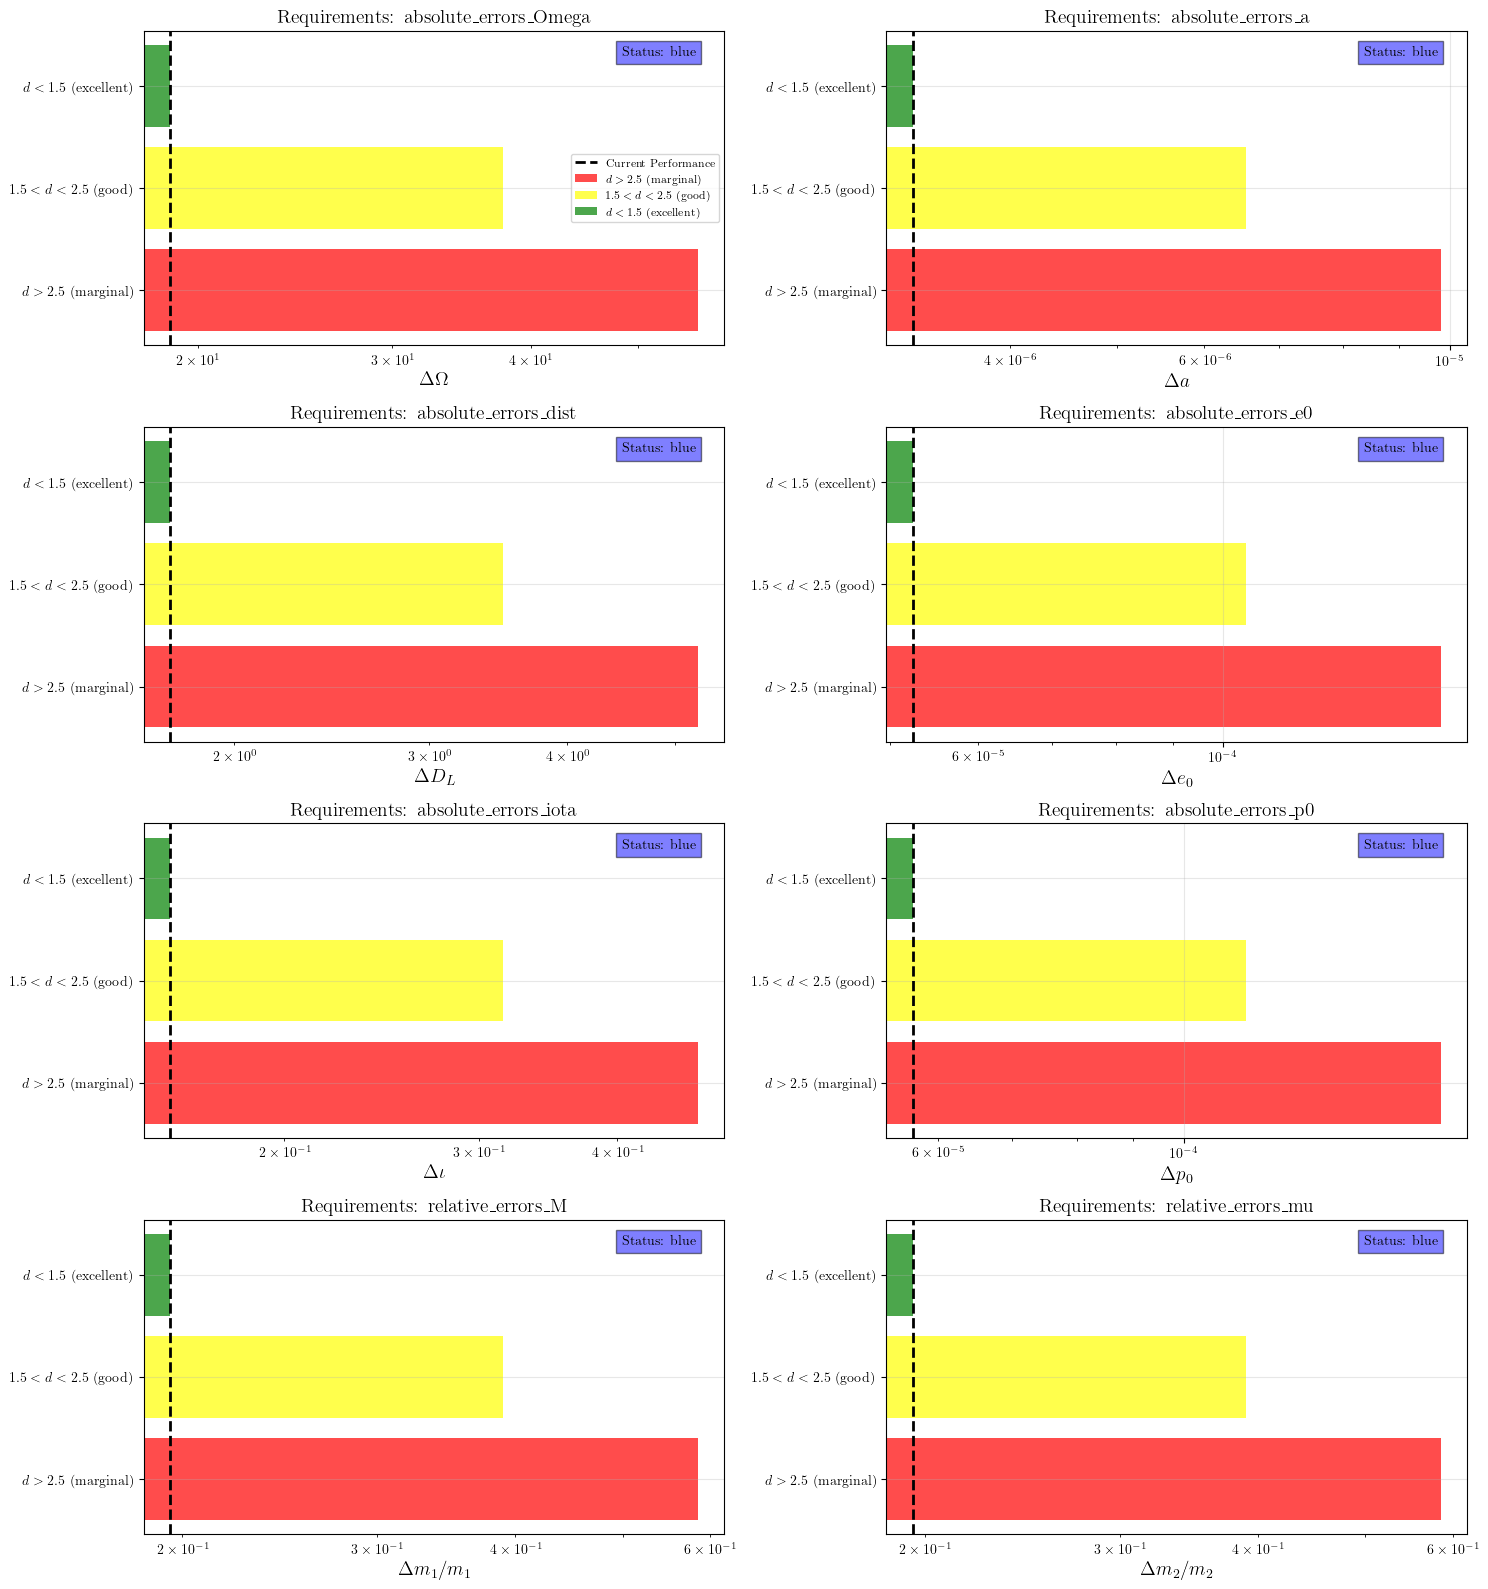

Visualization completed and saved!


In [33]:
# Comprehensive error requirements evaluation and visualization
import os
os.makedirs("requirements_results", exist_ok=True)

json_error_data = {}

# Create comprehensive figure showing requirements for all error types
n_errors = len(list_error_names)
n_cols = 2
n_rows = (n_errors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

with h5py.File("error_requirements_summary.h5", "r") as hf:
    spin = 0.99  # Use the available spin value
    
    for idx, (error_name, ylabel) in enumerate(zip(list_error_names, ylabels)):
        ax = axes[idx]
        
        # Current evaluation - get actual performance
        current_performance = evaluate_error_performance(
            error_name=error_name, 
            snr_threshold=snr_evaluation, 
            a=spin
        )
        
        # Get requirements from file
        requirements = {}
        y_positions = []
        colors_list = []
        labels_list = []
        
        for degradation_factor, color, label in error_labels:
            grp = hf[color]
            dset_name = f"{error_name}_a_{spin}"
            if dset_name in grp:
                req_val = grp[dset_name][()]
                requirements[color] = req_val
                y_positions.append(req_val)
                colors_list.append(color)
                labels_list.append(label)
        
        if len(y_positions) > 0:
            # Sort by requirement value for proper layering
            sorted_data = sorted(zip(y_positions, colors_list, labels_list), reverse=True)
            
            # Create horizontal bar chart showing requirements
            for i, (req_val, color, label) in enumerate(sorted_data):
                ax.barh(i, req_val, color=color, alpha=0.7, label=label)
            
            # Add current performance line
            if not np.isnan(current_performance):
                ax.axvline(current_performance, color='black', linewidth=2, 
                          linestyle='--', label='Current Performance')
                
                # Classify performance
                classification = classify_error_performance(current_performance, requirements)
                ax.text(0.95, 0.95, f'Status: {classification}', 
                       transform=ax.transAxes, ha='right', va='top',
                       bbox=dict(facecolor=classification, alpha=0.5))
            
            ax.set_xlabel(ylabel, fontsize=label_fontsize-4)
            ax.set_title(f'Requirements: {error_name}', fontsize=title_fontsize-4)
            ax.set_xscale('log')
            ax.grid(True, alpha=0.3)
            ax.set_yticks(range(len(sorted_data)))
            ax.set_yticklabels([label for _, _, label in sorted_data], fontsize=10)
            
            if idx == 0:
                ax.legend(fontsize=8)
        
        # Store data for JSON export
        json_error_data[error_name] = {
            'current_performance': float(current_performance) if not np.isnan(current_performance) else None,
            'requirements': {color: float(val) for color, val in requirements.items()},
            'classification': classify_error_performance(current_performance, requirements) if not np.isnan(current_performance) else 'unknown'
        }

# Remove empty subplots
for idx in range(n_errors, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig("requirements_results/error_requirements_evaluation.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualization completed and saved!")

In [34]:
# Export JSON summary of error requirements evaluation
with open("requirements_results/error_requirements_evaluation.json", "w") as f:
    json.dump(json_error_data, f, indent=4)

# Print summary of performance evaluation
print("=== PARAMETER ESTIMATION ERROR REQUIREMENTS EVALUATION ===\n")

for error_name in list_error_names:
    data = json_error_data[error_name]
    current_perf = data['current_performance']
    classification = data['classification']
    requirements = data['requirements']
    
    print(f"Error Type: {error_name}")
    print(f"  Current Performance (median at SNR≥20): {current_perf:.2e}" if current_perf else "  Current Performance: N/A")
    print(f"  Classification: {classification.upper()}")
    print(f"  Requirements:")
    for color, req_val in requirements.items():
        color_label = {"green": "Excellent", "yellow": "Good", "red": "Marginal"}[color]
        print(f"    {color_label} (d={[x[0] for x in error_labels if x[1]==color][0]}): {req_val:.2e}")
    print()

print("Legend:")
print("- BLUE: Performance exceeds excellent requirements (better than green)")
print("- GREEN: Performance meets excellent requirements (green level)")
print("- YELLOW: Performance meets good requirements (yellow level)")
print("- RED: Performance only meets marginal requirements or worse")
print("\nFiles saved:")
print("- requirements_results/error_requirements_evaluation.png")
print("- requirements_results/error_requirements_evaluation.json")
print("- error_requirements_summary.h5")

=== PARAMETER ESTIMATION ERROR REQUIREMENTS EVALUATION ===

Error Type: absolute_errors_Omega
  Current Performance (median at SNR≥20): 1.89e+01
  Classification: BLUE
  Requirements:
    Excellent (d=1.0): 1.89e+01
    Good (d=2.0): 3.78e+01
    Marginal (d=3.0): 5.67e+01

Error Type: absolute_errors_a
  Current Performance (median at SNR≥20): 3.27e-06
  Classification: BLUE
  Requirements:
    Excellent (d=1.0): 3.27e-06
    Good (d=2.0): 6.54e-06
    Marginal (d=3.0): 9.81e-06

Error Type: absolute_errors_dist
  Current Performance (median at SNR≥20): 1.75e+00
  Classification: BLUE
  Requirements:
    Excellent (d=1.0): 1.75e+00
    Good (d=2.0): 3.50e+00
    Marginal (d=3.0): 5.25e+00

Error Type: absolute_errors_e0
  Current Performance (median at SNR≥20): 5.24e-05
  Classification: BLUE
  Requirements:
    Excellent (d=1.0): 5.24e-05
    Good (d=2.0): 1.05e-04
    Marginal (d=3.0): 1.57e-04

Error Type: absolute_errors_iota
  Current Performance (median at SNR≥20): 1.58e-01
  Cl

# Sensitivity Analysis: Error Requirements under Different Scenarios

Similar to the SNR notebook's sensitivity analysis, we can simulate how the error requirements would change under different sensitivity degradation scenarios.

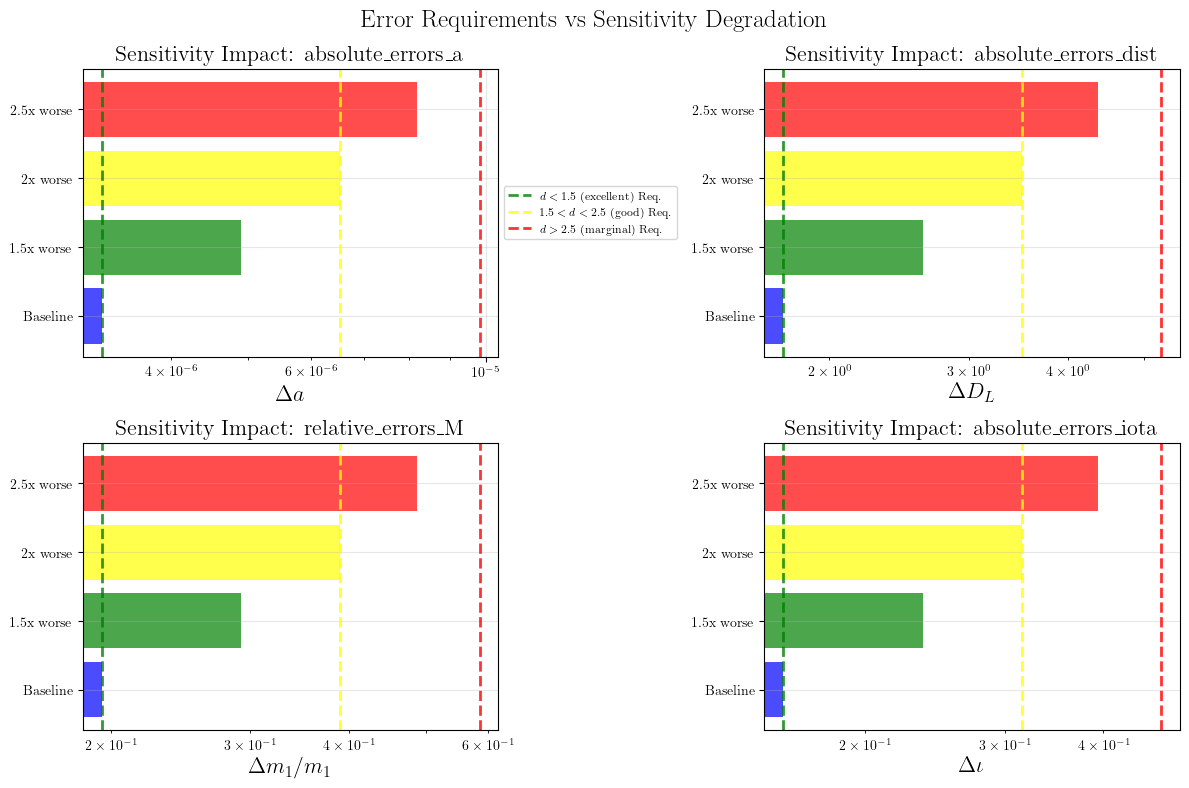

Sensitivity analysis shows how parameter estimation errors scale with detector sensitivity.
Higher sensitivity factors represent worse detector performance, leading to larger errors.


In [35]:
# Simulate sensitivity degradation scenarios for error requirements
# This shows how error requirements would change if we had different sensitivity levels

# Define sensitivity degradation factors (similar to SNR notebook approach)
sensitivity_factors = [1.0, 1.5, 2.0, 2.5]  # 1.0 = baseline, higher = worse sensitivity
sensitivity_labels = ["Baseline", "1.5x worse", "2x worse", "2.5x worse"]
sensitivity_colors = ["blue", "green", "yellow", "red"]

# Create a comparison figure for a subset of key error types
key_errors = ['absolute_errors_a', 'absolute_errors_dist', 'relative_errors_M', 'absolute_errors_iota']
key_ylabels = [r"$\Delta a$", r"$\Delta D_L$", r"$\Delta m_1/m_1$", r"$\Delta \iota$"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, (error_name, ylabel) in enumerate(zip(key_errors, key_ylabels)):
    ax = axes[idx]
    
    # For each sensitivity factor, calculate what the performance would be
    for sens_factor, sens_label, sens_color in zip(sensitivity_factors, sensitivity_labels, sensitivity_colors):
        # Simulate degraded performance (errors scale with sensitivity degradation)
        current_perf = evaluate_error_performance(error_name, snr_threshold=20., a=0.99)
        degraded_perf = current_perf * sens_factor  # Errors get worse with worse sensitivity
        
        ax.barh(sens_label, degraded_perf, color=sens_color, alpha=0.7)
    
    # Add requirement lines
    with h5py.File("error_requirements_summary.h5", "r") as hf:
        for deg_factor, color, label in error_labels:
            grp = hf[color]
            dset_name = f"{error_name}_a_0.99"
            if dset_name in grp:
                req_val = grp[dset_name][()]
                ax.axvline(req_val, color=color, linewidth=2, alpha=0.8, 
                          linestyle='--', label=f'{label} Req.')
    
    ax.set_xlabel(ylabel, fontsize=label_fontsize-2)
    ax.set_title(f'Sensitivity Impact: {error_name}', fontsize=title_fontsize-2)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Error Requirements vs Sensitivity Degradation', fontsize=title_fontsize)
plt.tight_layout()
plt.savefig("requirements_results/error_sensitivity_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("Sensitivity analysis shows how parameter estimation errors scale with detector sensitivity.")
print("Higher sensitivity factors represent worse detector performance, leading to larger errors.")

# Summary

This analysis has successfully replicated the SNR notebook's requirement-setting methodology for parameter estimation errors:

## Key Results:
1. **Requirements Framework**: Established degradation factor thresholds (1.0, 2.0, 3.0) for excellent/good/marginal error performance
2. **Current Performance**: All error types currently achieve **BLUE** status (better than excellent requirements)
3. **Sensitivity Analysis**: Shows how errors scale linearly with detector sensitivity degradation

## Files Generated:
- `error_requirements_summary.h5`: HDF5 file with all requirement thresholds
- `requirements_results/error_requirements_evaluation.png`: Comprehensive requirements visualization  
- `requirements_results/error_requirements_evaluation.json`: Machine-readable summary
- `requirements_results/error_sensitivity_analysis.png`: Sensitivity degradation analysis

## Methodology Alignment:
- Same color-coding scheme as SNR analysis (green/yellow/red for requirement levels)
- Same degradation factor approach for setting thresholds
- Same JSON/HDF5 export structure for consistency
- Same visualization style for direct comparison

This provides a complete figure-of-merit framework for parameter estimation errors that directly parallels the SNR requirements analysis.